## BI Project

In [2]:
import time
from math import ceil
from joblib import dump, load
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.model_selection import KFold
from scipy import stats
from sklearn import preprocessing

In [3]:
data = pd.read_csv('DataCoSupplyChainDataset.csv')

In [4]:
data.shape

(180519, 53)

In [5]:
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [78]:
data.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Delivery Status                   object
Late_delivery_risk                 int64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Email                    object
Customer Fname                    object
Customer Id                        int64
Customer Lname                    object
Customer Password                 object
Customer Segment                  object
Customer State                    object
Customer Street                   object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Latitude                         float64
Longitude                        float64
Market          

In [6]:
metric_features = []

for col in data.columns:
    if data[col].dtype != "object":
        metric_features.append(col)

In [7]:
data[metric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Days for shipping (real),180519.0,3.497654,1.623722,0.000000,2.000000,3.000000,5.000000,6.000000
Days for shipment (scheduled),180519.0,2.931847,1.374449,0.000000,2.000000,4.000000,4.000000,4.000000
Benefit per order,180519.0,21.974989,104.433526,-4274.979980,7.000000,31.520000,64.800003,911.799988
Sales per customer,180519.0,183.107609,120.043670,7.490000,104.379997,163.990005,247.399994,1939.989990
Late_delivery_risk,180519.0,0.548291,0.497664,0.000000,0.000000,1.000000,1.000000,1.000000
Category Id,180519.0,31.851451,15.640064,2.000000,18.000000,29.000000,45.000000,76.000000
Customer Id,180519.0,6691.379495,4162.918106,1.000000,3258.500000,6457.000000,9779.000000,20757.000000
Customer Zipcode,180516.0,35921.126914,37542.461122,603.000000,725.000000,19380.000000,78207.000000,99205.000000
Department Id,180519.0,5.443460,1.629246,2.000000,4.000000,5.000000,7.000000,12.000000
Latitude,180519.0,29.719955,9.813646,-33.937553,18.265432,33.144863,39.279617,48.781933


In [60]:
(data["Days for shipping (real)"] > data["Days for shipment (scheduled)"]).value_counts()

True     103400
False     77119
dtype: int64

In [67]:
103400/180519

0.5727928916069777

In [8]:
non_metric_features = []

for col in data.columns:
    if data[col].dtype == "object":
        non_metric_features.append(col)

data[non_metric_features].describe().T

,count,unique,top,freq
Type,180519,4,DEBIT,69295
Delivery Status,180519,4,Late delivery,98977
Category Name,180519,50,Cleats,24551
Customer City,180519,563,Caguas,66770
Customer Country,180519,2,EE. UU.,111146
Customer Email,180519,1,XXXXXXXXX,180519
Customer Fname,180519,782,Mary,65150
Customer Lname,180511,1109,Smith,64104
Customer Password,180519,1,XXXXXXXXX,180519
Customer Segment,180519,3,Consumer,93504


In [85]:
data.groupby("Customer Segment") ["Order Id"].count().sort_values(ascending = False).head(10)

Customer Segment
Consumer       93504
Corporate      54789
Home Office    32226
Name: Order Id, dtype: int64

In [86]:
93504/180519

0.5179731773386735

In [82]:
data.groupby("Delivery Status") ["Order Id"].count().sort_values(ascending = False).head(10)

Delivery Status
Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled     7754
Name: Order Id, dtype: int64

In [81]:
data.groupby(["Customer Country", 'Customer City']) ["Order Id"].count().sort_values(ascending = False).head(10)

Customer Country  Customer City
Puerto Rico       Caguas           66770
EE. UU.           Chicago           3885
                  Los Angeles       3417
                  Brooklyn          3412
                  New York          1816
                  Philadelphia      1577
                  Bronx             1500
                  San Diego         1437
                  Miami             1314
                  Houston           1297
Name: Order Id, dtype: int64

In [79]:
data.groupby("Category Name") ["Order Id"].count().sort_values(ascending = False).head(50)

Category Name
Cleats                  24551
Men's Footwear          22246
Women's Apparel         21035
Indoor/Outdoor Games    19298
Fishing                 17325
Water Sports            15540
Camping & Hiking        13729
Cardio Equipment        12487
Shop By Sport           10984
Electronics              3156
Accessories              1780
Golf Balls               1475
Girls' Apparel           1201
Golf Gloves              1070
Trade-In                  974
Video Games               838
Children's Clothing       652
Women's Clothing          650
Baseball & Softball       632
Hockey                    614
Cameras                   592
Toys                      529
Golf Shoes                524
Pet Supplies              492
Crafts                    484
Garden                    484
DVDs                      483
Computers                 442
Golf Apparel              441
Hunting & Shooting        440
Music                     434
Consumer Electronics      431
Boxing & MMA              

In [54]:
data.groupby("Department Name") ["Order Id"].count().sort_values(ascending = False).head(10)

Department Name
Fan Shop      66861
Apparel       48998
Golf          33220
Footwear      14525
Outdoors       9686
Fitness        2479
Discs Shop     2026
Technology     1465
Pet Shop        492
Book Shop       405
Name: Order Id, dtype: int64

In [56]:
data.groupby('Order Country') ["Order Id"].count().sort_values(ascending = False).head(10)

Order Country
Estados Unidos    24840
Francia           13222
M�xico            13172
Alemania           9564
Australia          8497
Brasil             7987
Reino Unido        7302
China              5758
Italia             4989
India              4783
Name: Order Id, dtype: int64

In [57]:
data.groupby("Market") ["Order Id"].count().sort_values(ascending = False).head(10)

Market
LATAM           51594
Europe          50252
Pacific Asia    41260
USCA            25799
Africa          11614
Name: Order Id, dtype: int64

In [59]:
data.groupby(["Order Country",'Order City']) ["Order Id"].count().sort_values(ascending = False).head(10)

Order Country         Order City   
Rep�blica Dominicana  Santo Domingo    2211
Estados Unidos        New York City    2202
                      Los Angeles      1845
Honduras              Tegucigalpa      1783
Nicaragua             Managua          1682
M�xico                Mexico City      1484
Filipinas             Manila           1381
Estados Unidos        Philadelphia     1302
                      San Francisco    1297
El Salvador           San Salvador     1135
Name: Order Id, dtype: int64

In [30]:
data.isna().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [36]:
data.duplicated().sum()

0

In [31]:
(data ["Benefit per order"]<0).value_counts()

False    146735
True      33784
Name: Benefit per order, dtype: int64

In [89]:
33784/(146735+33784)

0.18714927514555255

In [35]:
(data["Order Profit Per Order"] <0).value_counts()

False    146735
True      33784
Name: Order Profit Per Order, dtype: int64

In [33]:
(data["Order Item Profit Ratio"] <0).value_counts()

False    146735
True      33784
Name: Order Item Profit Ratio, dtype: int64

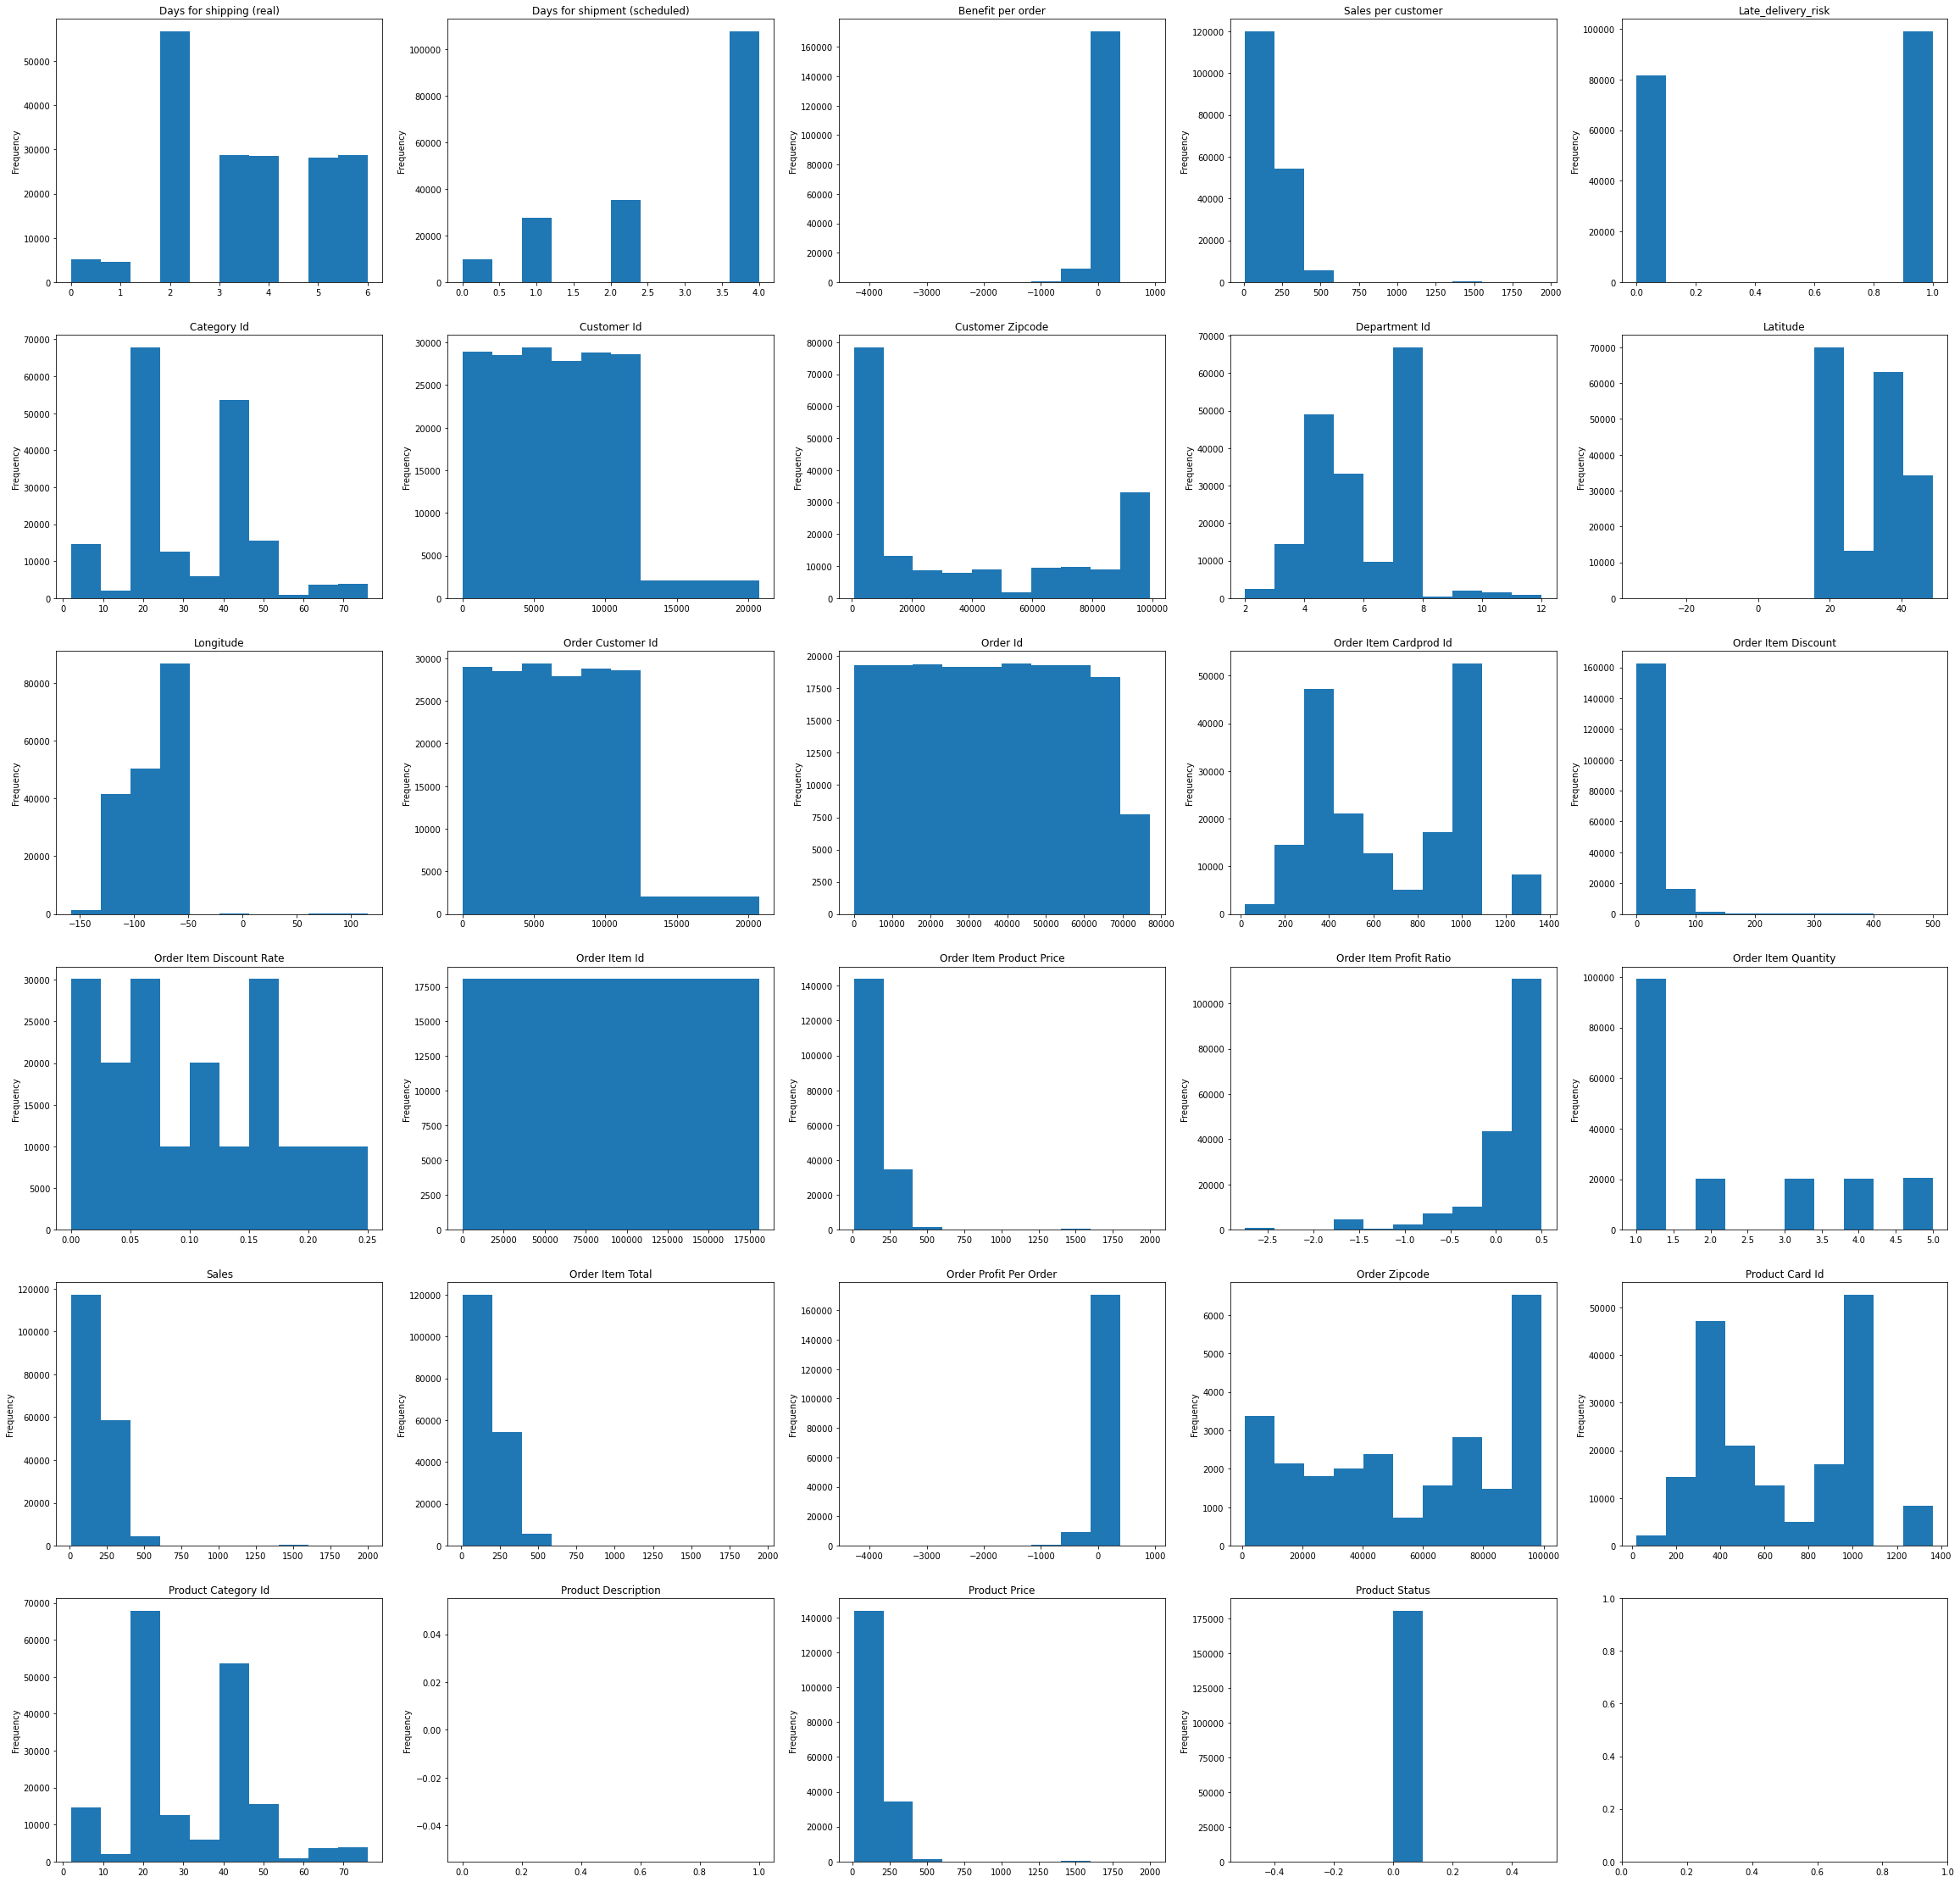

In [23]:
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(6,5,figsize=(40,40))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): 
    data[feat].plot(kind="hist", ax=ax, title=feat)


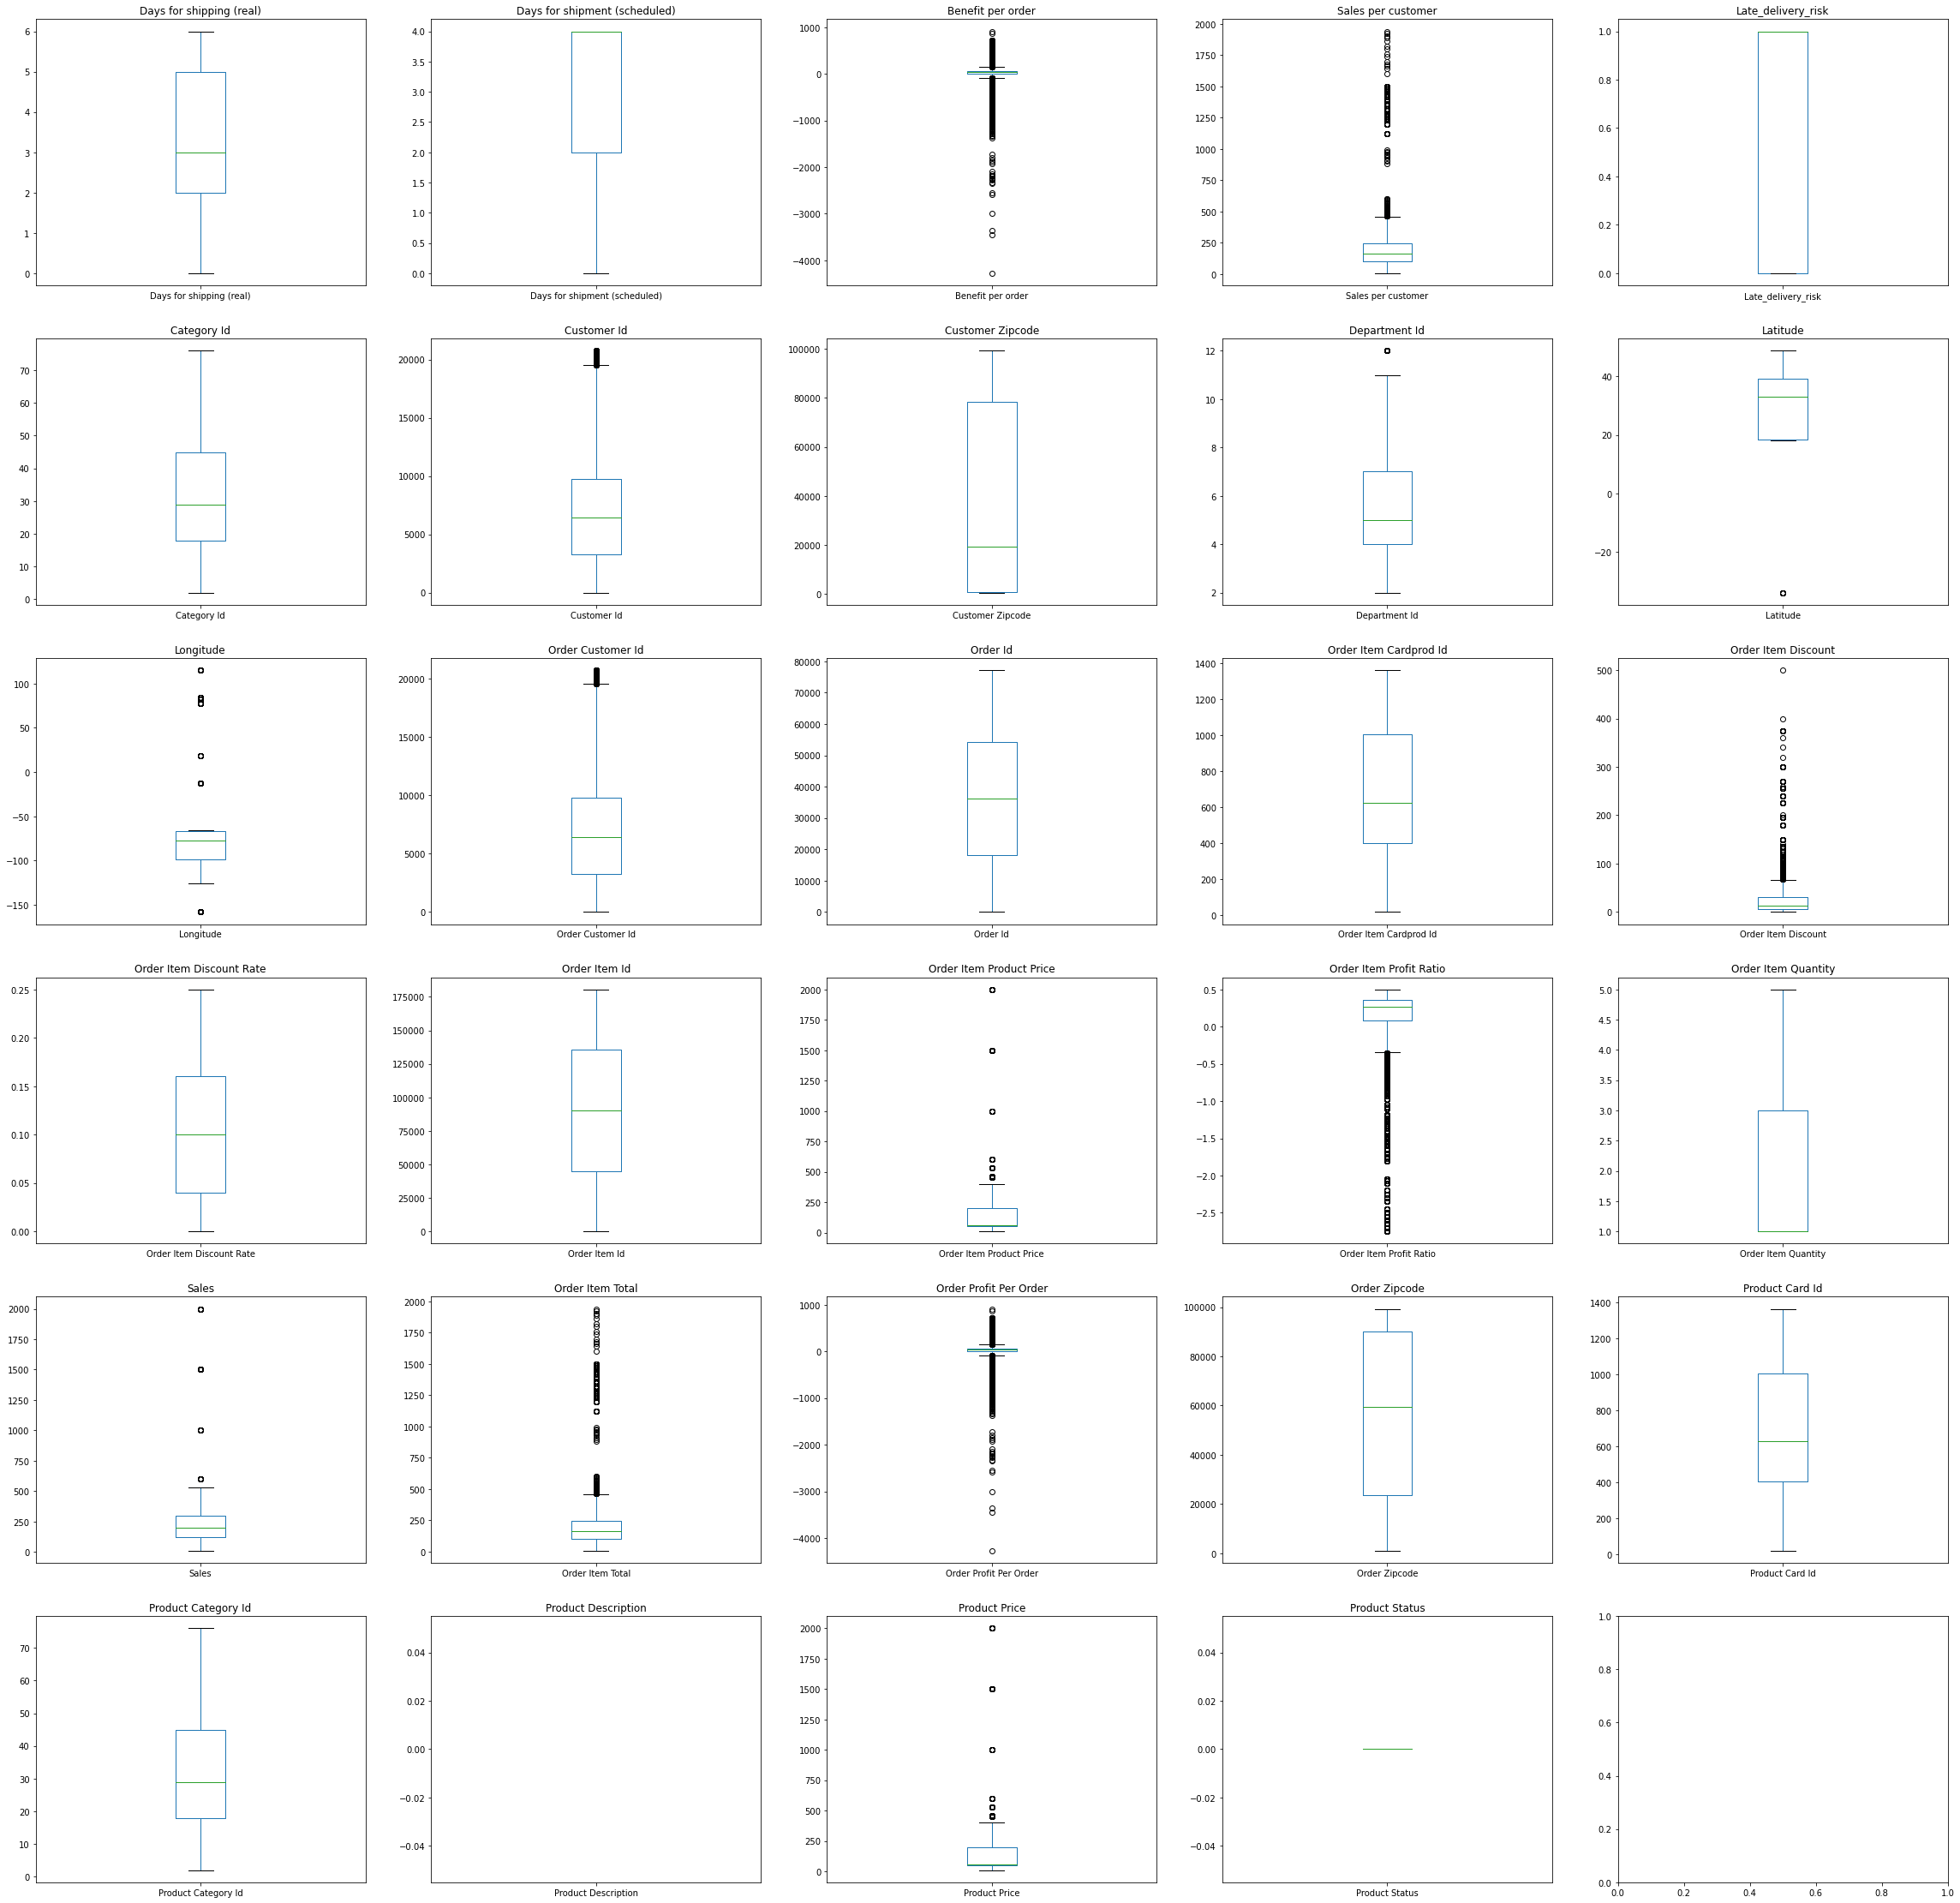

In [37]:
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(6, 5, figsize=(40, 40))

# Plot data
for ax, feat in zip(axes.flatten(), metric_features): 
    data[feat].plot(kind="box", ax=ax, title=feat)


plt.show()

In [42]:
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(5, 7, figsize=(23, 35))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): 
    data[feat].value_counts().plot(kind="bar", ax=ax, title=feat)

plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002ACC360D940> (for post_execute):


KeyboardInterrupt: 

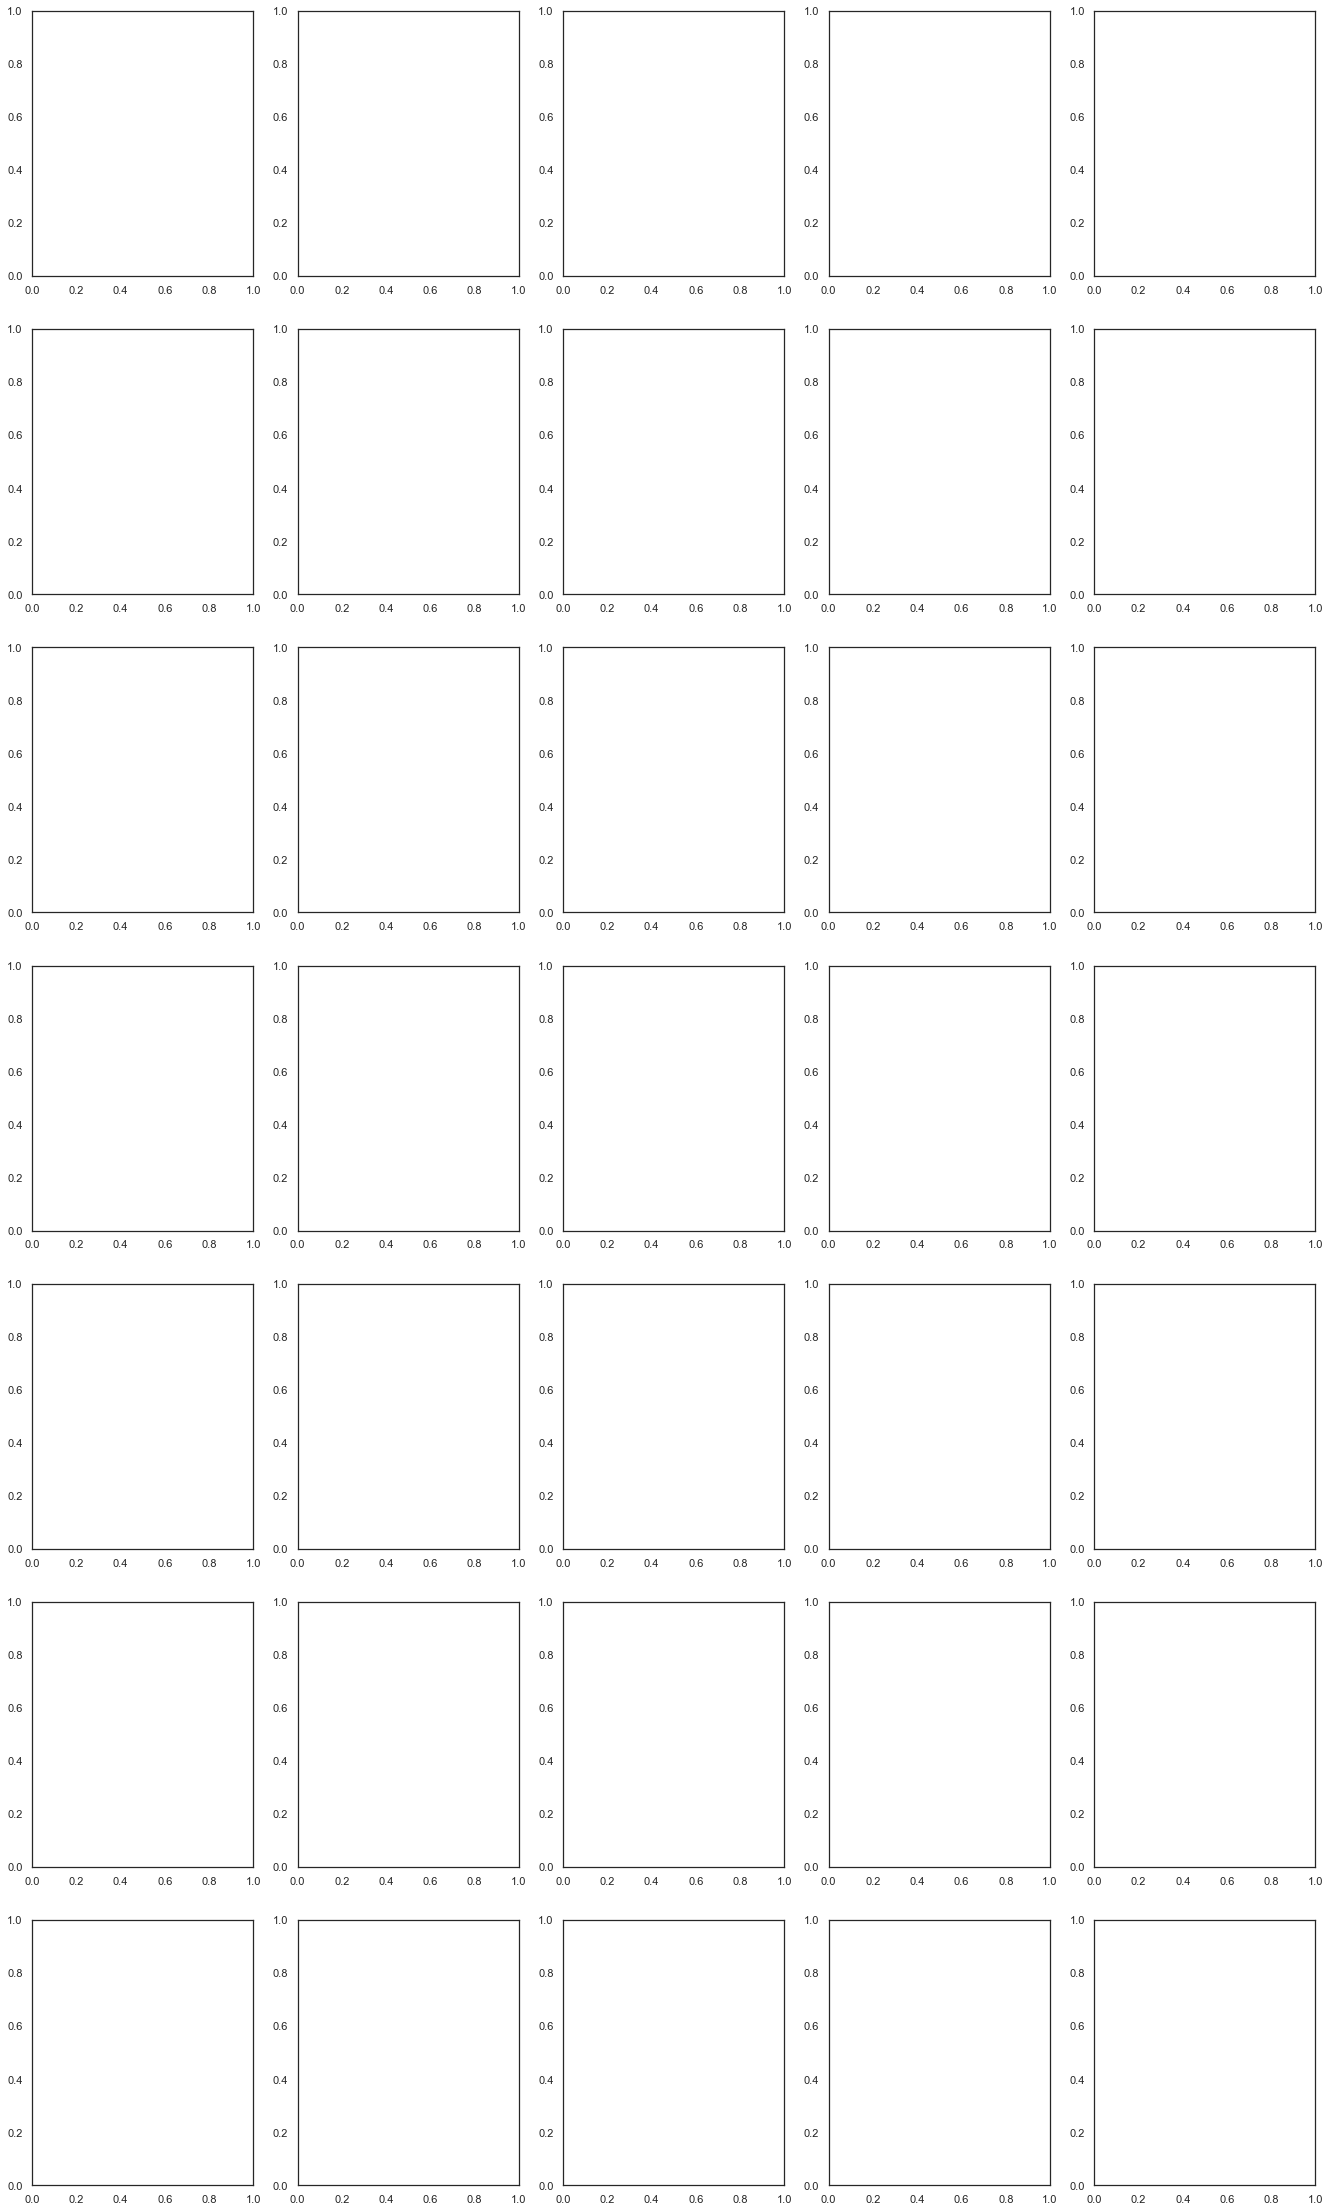

In [41]:
def categorical_cardinality_plot(df, features):
    # figure and axes
    fig, axes = plt.subplots(7, 5, figsize=(23,40))

    # plot data
    for ax, feat in zip(axes.flatten(), non_metric_features): 
        df = pd.DataFrame(data[feat].value_counts()/len(data[feat]))
        df.rename(columns={feat:"Relative Frequency"}, inplace=True)

    plt.show()
    
plot_df = data[non_metric_features]
plot_features = non_metric_features

categorical_cardinality_plot(plot_df, plot_features)